# SYNC BOUND SUM - DOUBLE PRODUCTION

In [1]:
import sys
sys.path.append('../../../')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import redis
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)
import tensorflow as tf
import numpy as np

from distribution.watcher import SynchronousBoundSum
from machine_learning.models import DoubleProduction
tf.random.set_seed(42)

In [2]:
model = DoubleProduction()


Load database helpers

In [3]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [4]:
def avg(lst):
    sum = 0
    for i in lst:
        sum += float(i.decode("utf-8"))
    return sum / len(lst)

## First run

In [7]:
loss = {}
recall = {}
precision = {}
auc = {}
throughput = {}
total_time = {}
avg_pass_time = {}
read_time = {}
write_time = {}


threshold_limit = [1, 2, 4, 8, 16, 32, 64, 128]# 4, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
num_workers = [2, 4, 8]

for i in num_workers:
    loss[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: Loss_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    recall[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: Recall_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    precision[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: Precision_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    auc[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: Auc_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]

    throughput[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: Throughput_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    total_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: TotalTime_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    avg_pass_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: AvgPass_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    read_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: read_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    write_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousBoundSum.name}: write_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]

resutls

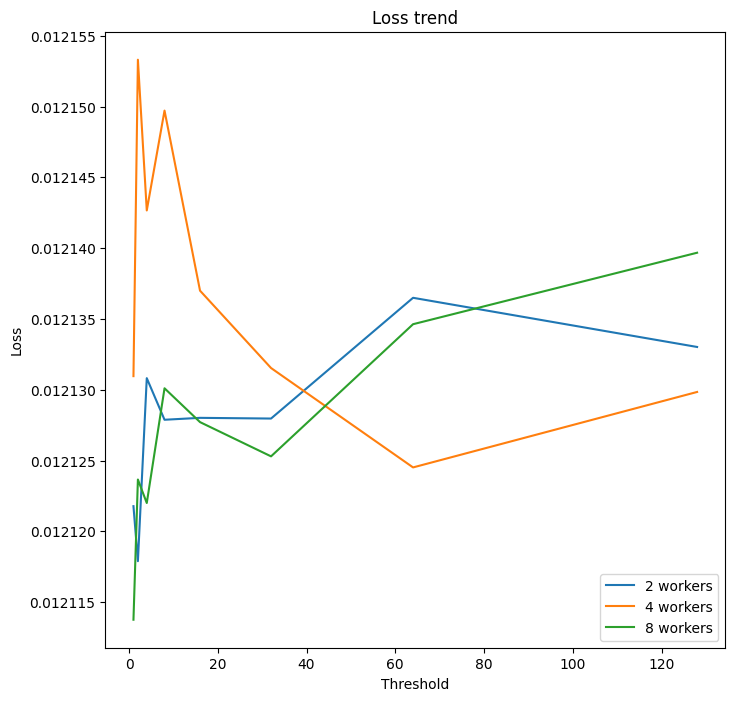

In [8]:
for i in num_workers:
    plt.plot(threshold_limit, loss[i], label=f'{i} workers')
#plt.plot([0, 100], [loss_ub, loss_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [loss_lb, loss_lb], 'r--', label=f'randomized state')

plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.title('Loss trend')
plt.legend(loc="lower right")
plt.show()


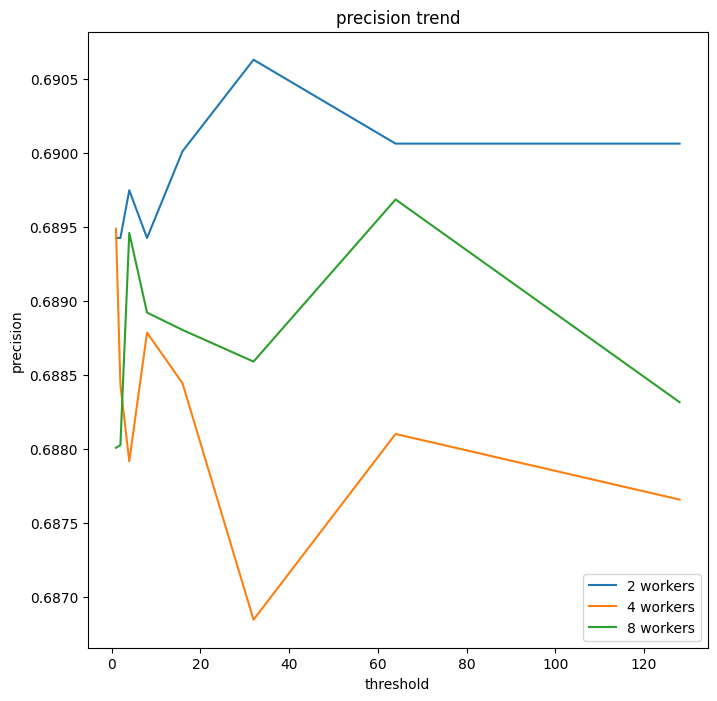

In [9]:
for i in num_workers:
    plt.plot(threshold_limit, precision[i], label=f'{i} workers')
# plt.plot([0, 100], [prc_ub, prc_ub], 'b--', label=f'no distribution')
# plt.plot([0, 100], [prc_lb, prc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('precision')
plt.title('precision trend')
plt.legend(loc="lower right")
plt.show()

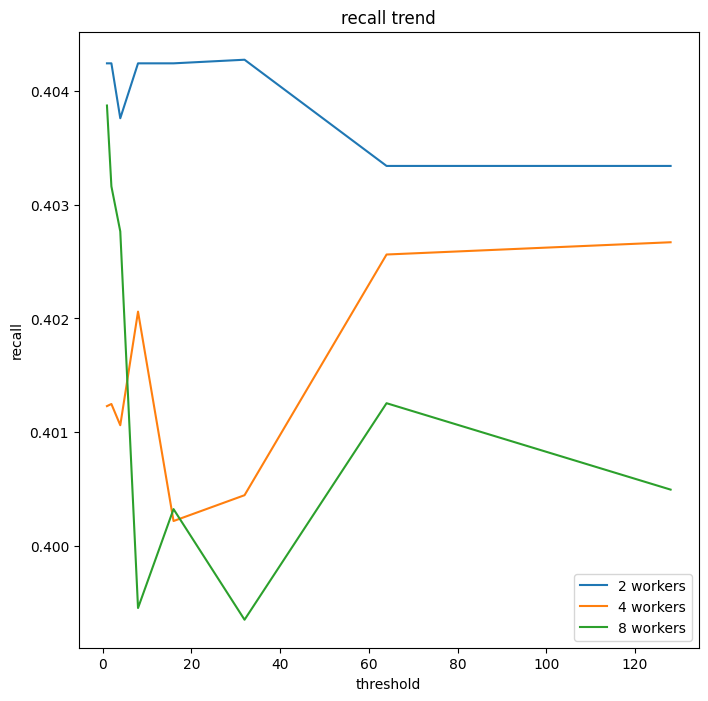

In [10]:
for i in num_workers:
    plt.plot(threshold_limit, recall[i], label=f'{i} workers')
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('recall')
plt.title('recall trend')
plt.legend(loc="lower right")
plt.show()

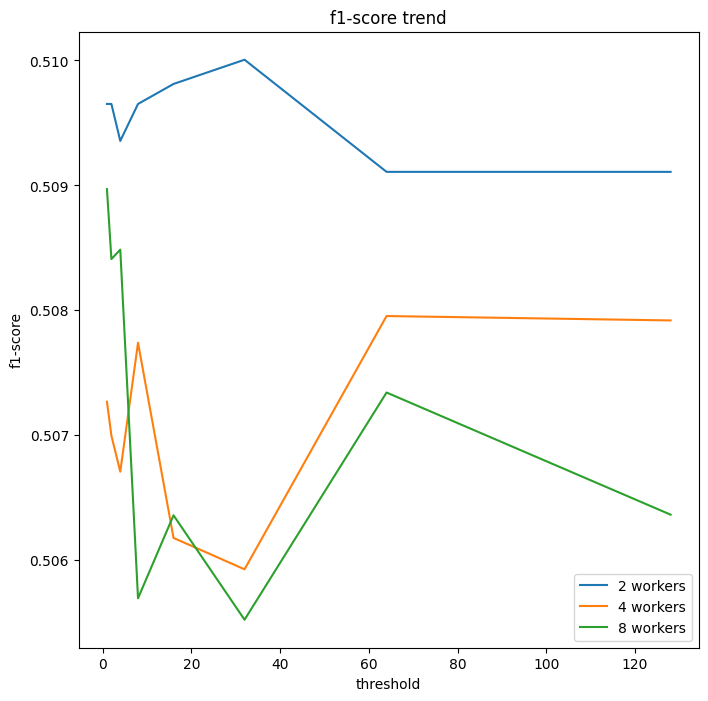

In [11]:
for i in num_workers:
    f1_score = []
    for prc, rc in zip(precision[i], recall[i]):
        f1_score.append(2 * (prc * rc) / (prc + rc))
    plt.plot(threshold_limit, f1_score, label=f'{i} workers')
# plt.plot([0, 100], [2 * (prc_ub * rc_ub) / (prc_ub + rc_ub), 2 * (prc_ub * rc_ub) / (prc_ub + rc_ub)], 'b--', label="no distribution")
# plt.plot([0, 100], [2 * (prc_lb * rc_lb) / (prc_lb + rc_lb), 2 * (prc_lb * rc_lb) / (prc_lb + rc_lb)], 'r--', label="randomized state")

plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('f1-score trend')
plt.legend(loc="lower right")
plt.show()

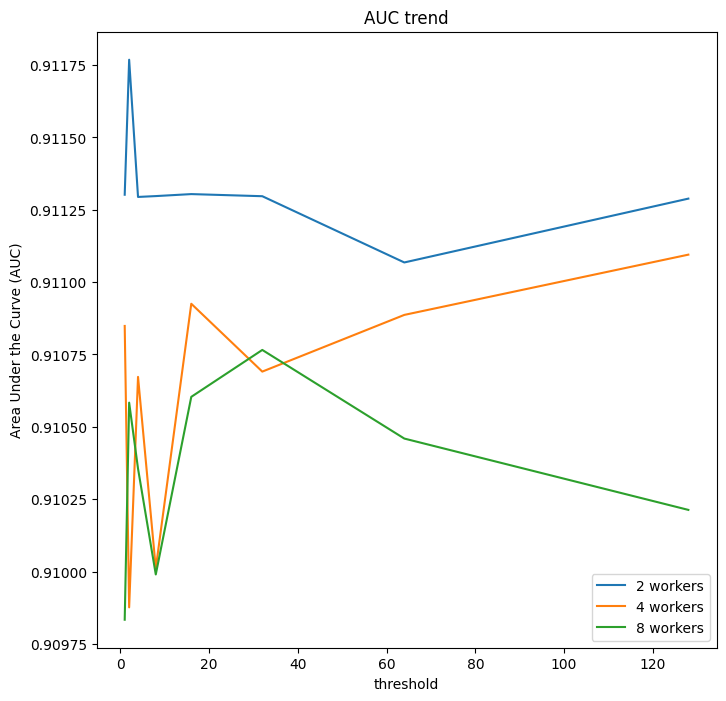

In [12]:
for i in num_workers:
    plt.plot(threshold_limit, auc[i], label=f'{i} workers')
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('Area Under the Curve (AUC)')
plt.title('AUC trend')
plt.legend(loc="lower right")
plt.show()

## Second run

In [ ]:
loss = {}
recall = {}
precision = {}
auc = {}
throughput = {}
total_time = {}
avg_pass_time = {}
read_time = {}
write_time = {}


threshold_limit = [8, 16, 32, 64]# 4, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
num_workers = [8]

for i in num_workers:
    loss[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: Loss_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    recall[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: Recall_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    precision[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: Precision_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    auc[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: Auc_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]

    throughput[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: Throughput_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    total_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: TotalTime_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    avg_pass_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: AvgPass_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    read_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: read_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    write_time[i] = [avg(r.lrange(f'{model.name}_{SynchronousAverage.name}: write_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]

resutls

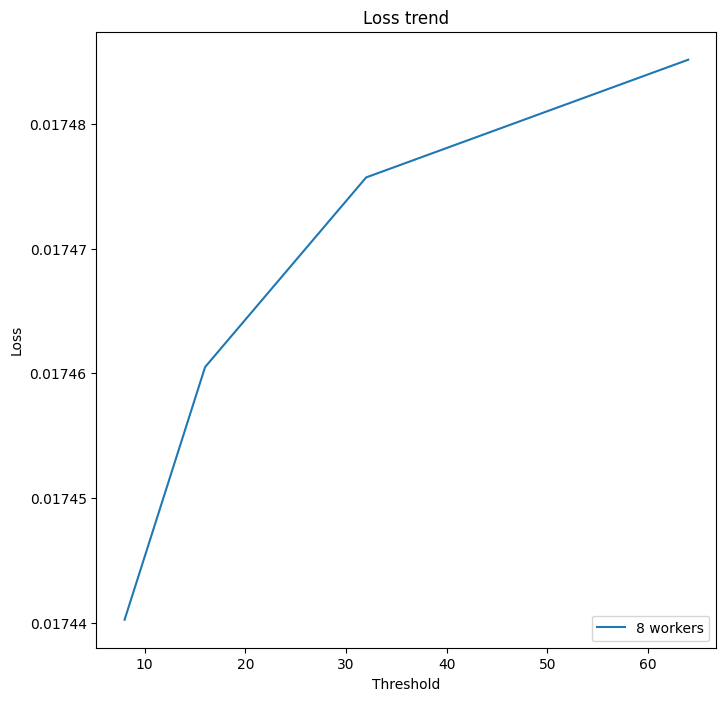

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, loss[i], label=f'{i} workers')
#plt.plot([0, 100], [loss_ub, loss_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [loss_lb, loss_lb], 'r--', label=f'randomized state')

plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.title('Loss trend')
plt.legend(loc="lower right")
plt.show()


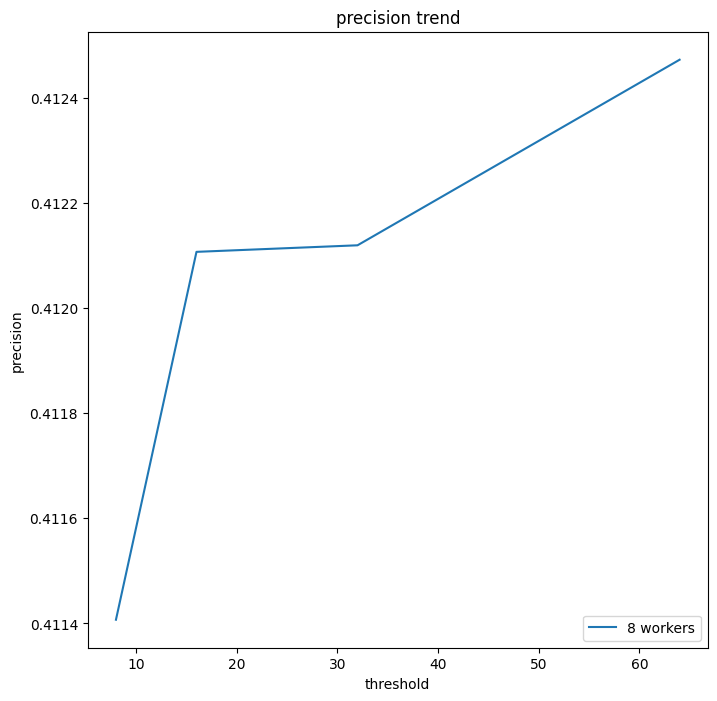

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, precision[i], label=f'{i} workers')
# plt.plot([0, 100], [prc_ub, prc_ub], 'b--', label=f'no distribution')
# plt.plot([0, 100], [prc_lb, prc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('precision')
plt.title('precision trend')
plt.legend(loc="lower right")
plt.show()

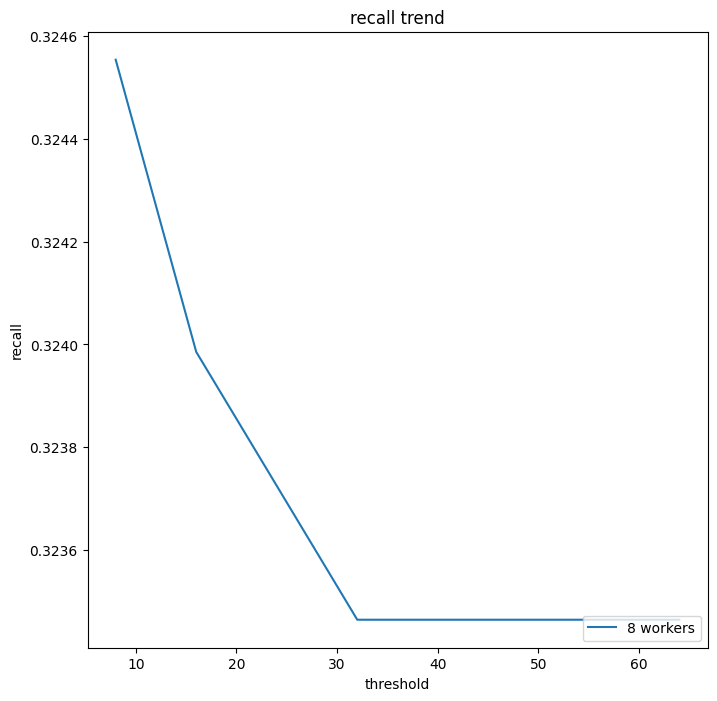

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, recall[i], label=f'{i} workers')
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('recall')
plt.title('recall trend')
plt.legend(loc="lower right")
plt.show()

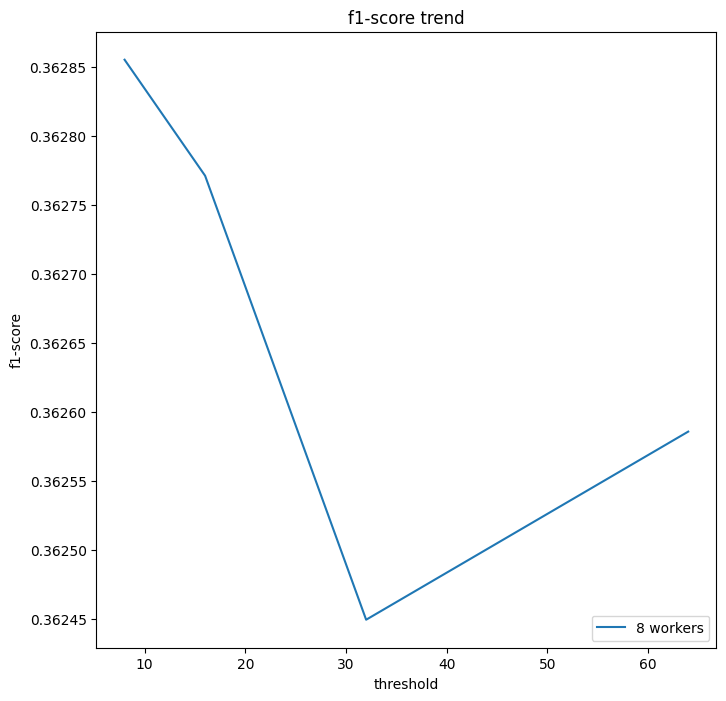

In [ ]:
for i in num_workers:
    f1_score = []
    for prc, rc in zip(precision[i], recall[i]):
        f1_score.append(2 * (prc * rc) / (prc + rc))
    plt.plot(threshold_limit, f1_score, label=f'{i} workers')
# plt.plot([0, 100], [2 * (prc_ub * rc_ub) / (prc_ub + rc_ub), 2 * (prc_ub * rc_ub) / (prc_ub + rc_ub)], 'b--', label="no distribution")
# plt.plot([0, 100], [2 * (prc_lb * rc_lb) / (prc_lb + rc_lb), 2 * (prc_lb * rc_lb) / (prc_lb + rc_lb)], 'r--', label="randomized state")

plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('f1-score trend')
plt.legend(loc="lower right")
plt.show()

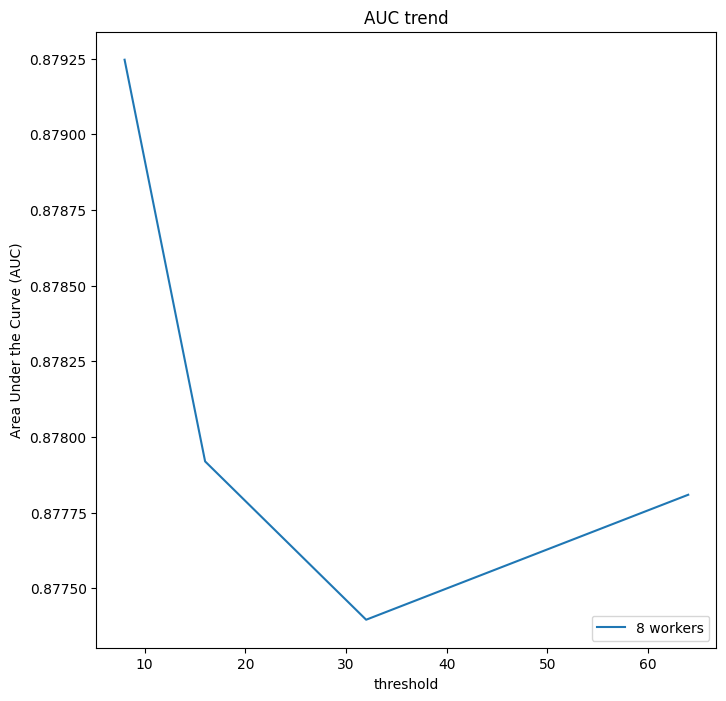

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, auc[i], label=f'{i} workers')
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('Area Under the Curve (AUC)')
plt.title('AUC trend')
plt.legend(loc="lower right")
plt.show()

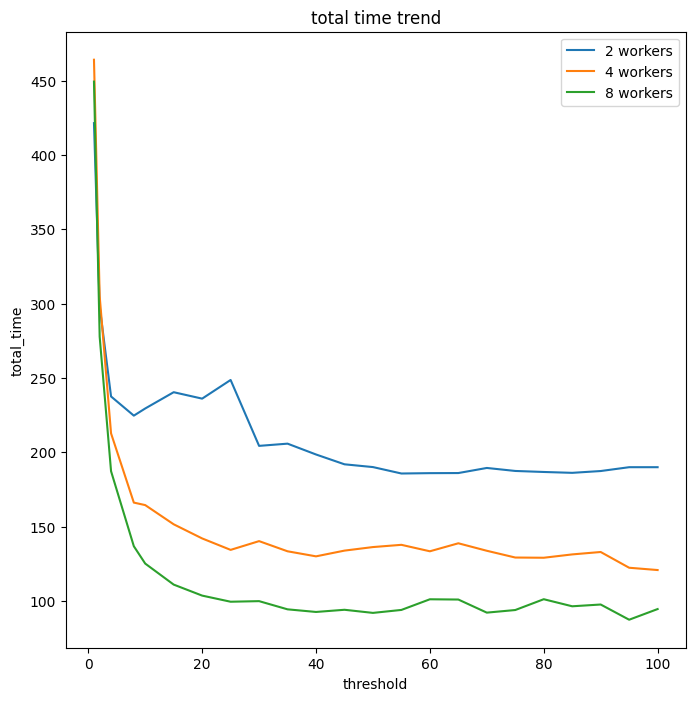

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, total_time[i], label=f'{i} workers')
plt.xlabel('threshold')
plt.ylabel('total_time')
plt.title('total time trend')
plt.legend(loc="upper right")
plt.show()

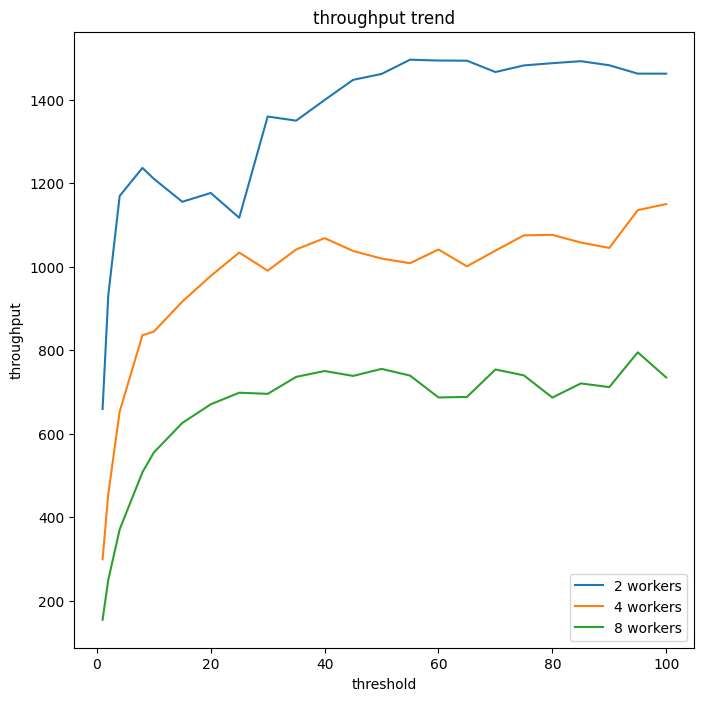

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, throughput[i], label=f'{i} workers')
plt.xlabel('threshold')
plt.ylabel('throughput')
plt.title('throughput trend')
plt.legend(loc="lower right")
plt.show()

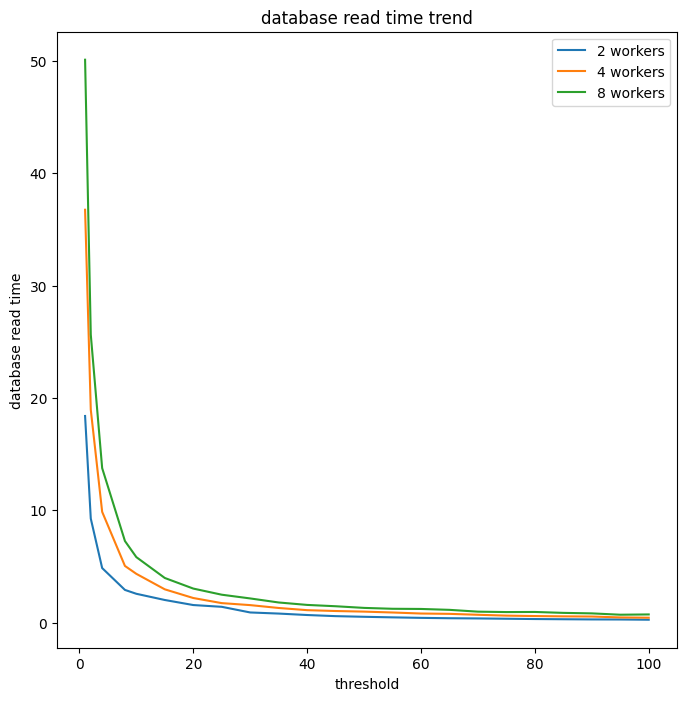

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, read_time[i], label=f'{i} workers')

    
plt.xlabel('threshold')
plt.ylabel('database read time')
plt.title('database read time trend')
plt.legend(loc="upper right")
plt.show()

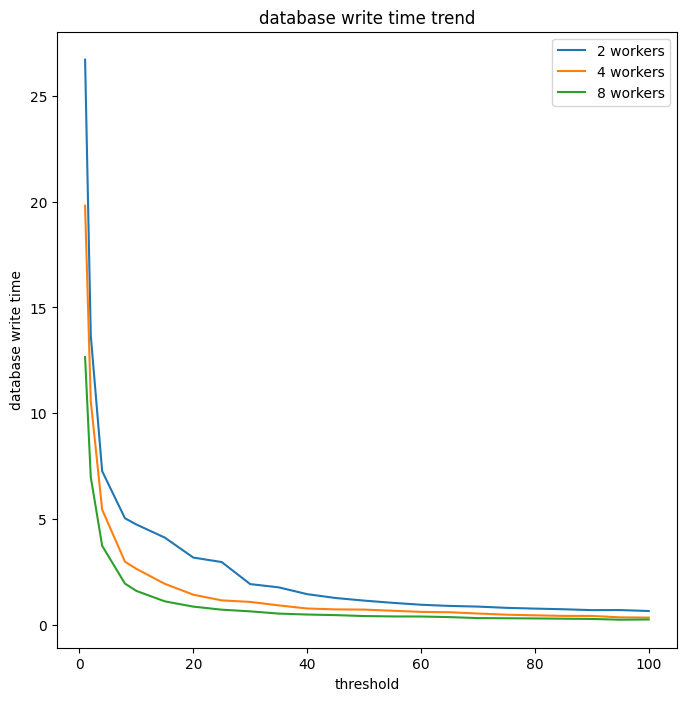

In [ ]:
for i in num_workers:
    plt.plot(threshold_limit, write_time[i], label=f'{i} workers')

    
plt.xlabel('threshold')
plt.ylabel('database write time')
plt.title('database write time trend')
plt.legend(loc="upper right")
plt.show()